# TensorFlow2教程-Keras函数式API

函数API是一种创建模型的方式，该方法比Sequential以下方法更加灵活：它可以处理具有非线性拓扑的模型，具有共享层的模型以及具有多个输入或输出的模型。

它基于以下思想：深度学习模型通常是层的有向无环图（DAG）。Functional API是一组用于构建层图的工具。

In [1]:
# !pip install pydot
#!sudo apt-get install graphvizf

In [2]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
tf.keras.backend.clear_session()

/home/doit/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1 构建简单的网络
### 1.1 创建网络

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


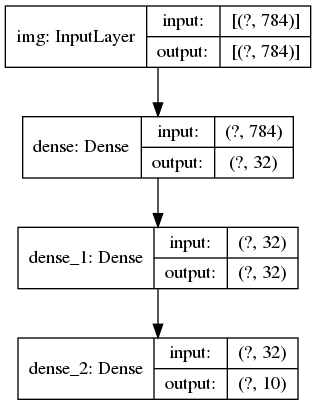

In [3]:

inputs = tf.keras.Input(shape=(784,), name='img')
# 以上一层的输出作为下一层的输入
h1 = layers.Dense(32, activation='relu')(inputs)
h2 = layers.Dense(32, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h2)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')  # 名字字符串中不能有空格

model.summary()
keras.utils.plot_model(model, 'mnist_model.png')
keras.utils.plot_model(model, 'model_info.png', show_shapes=True)

“层图”是用于深度学习模型的非常直观的结构图，而函数式API是构建结构图对应模型的方法。

### 1.2 训练、验证及测试

In [4]:
# 模型的训练、验证和测试与训练模型完全相同
# 下面使用mnist数据集进行展示
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# 将数值归到0-1之间
x_train = x_train.reshape(60000, 784).astype('float32') /255
x_test = x_test.reshape(10000, 784).astype('float32') /255
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss='sparse_categorical_crossentropy', # 直接填api，后面会报错
             metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=0)
print('test loss:', test_scores[0])
print('test acc:', test_scores[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 3s 53us/sample - loss: 0.4210 - accuracy: 0.8833 - val_loss: 0.2289 - val_accuracy: 0.9322
Epoch 2/5
48000/48000 [==============================] - 1s 27us/sample - loss: 0.2056 - accuracy: 0.9399 - val_loss: 0.1690 - val_accuracy: 0.9501
Epoch 3/5
48000/48000 [==============================] - 1s 27us/sample - loss: 0.1633 - accuracy: 0.9516 - val_loss: 0.1466 - val_accuracy: 0.9568
Epoch 4/5
48000/48000 [==============================] - 1s 27us/sample - loss: 0.1403 - accuracy: 0.9585 - val_loss: 0.1343 - val_accuracy: 0.9594
Epoch 5/5
48000/48000 [==============================] - 1s 27us/sample - loss: 0.1235 - accuracy: 0.9638 - val_loss: 0.1311 - val_accuracy: 0.9579
test loss: 0.13712323768194765
test acc: 0.959


### 1.3 模型保存和序列化

In [5]:
# 模型的保存与序列化与Sequential模型完全一样
model.save('model_save.h5')
del model
model = keras.models.load_model('model_save.h5')

## 2 使用共享网络创建多个模型
在函数式API中，通过在图层网络中指定其输入和输出来创建模型。 这意味着可以使用单个图层图来生成多个模型。

In [6]:
# 自编码器网络结构
# 编码器
encode_input = keras.Input(shape=(28,28,1), name='img')
h1 = layers.Conv2D(16, 3, activation='relu')(encode_input)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.MaxPool2D(3)(h1)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.Conv2D(16, 3, activation='relu')(h1)
encode_output = layers.GlobalMaxPool2D()(h1)

encode_model = keras.Model(inputs=encode_input, outputs=encode_output, name='encoder')
encode_model.summary()
# 解码器
h2 = layers.Reshape((4, 4, 1))(encode_output)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
h2 = layers.Conv2DTranspose(32, 3, activation='relu')(h2)
h2 = layers.UpSampling2D(3)(h2)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
decode_output = layers.Conv2DTranspose(1, 3, activation='relu')(h2)

autoencoder = keras.Model(inputs=encode_input, outputs=decode_output, name='autoencoder')
autoencoder.summary()





Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

请注意，我们使解码架构与编码架构严格对称，因此我们得到的输出形状与输入形状相同(28, 28, 1)。Conv2D一层的反面是Conv2DTranspose一层，MaxPooling2D一层的反面是UpSampling2D一层。

**可以把整个模型，当作一层网络使用**
我们可以通过在另一层的Input或Output上调用任何模型，将其视为层。请注意，通过调用模型，我们不仅可以重用模型的体系结构，还可以重用其权重。

下面是对自动编码器示例的另一种处理方式，该示例创建一个编码器模型，一个解码器模型，并将它们链接到两个调用中以获得自编码器模型：



In [7]:
encode_input = keras.Input(shape=(28,28,1), name='src_img')
h1 = layers.Conv2D(16, 3, activation='relu')(encode_input)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.MaxPool2D(3)(h1)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.Conv2D(16, 3, activation='relu')(h1)
encode_output = layers.GlobalMaxPool2D()(h1)

encode_model = keras.Model(inputs=encode_input, outputs=encode_output, name='encoder')
encode_model.summary()

decode_input = keras.Input(shape=(16,), name='encoded_img')
h2 = layers.Reshape((4, 4, 1))(decode_input)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
h2 = layers.Conv2DTranspose(32, 3, activation='relu')(h2)
h2 = layers.UpSampling2D(3)(h2)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
decode_output = layers.Conv2DTranspose(1, 3, activation='relu')(h2)
decode_model = keras.Model(inputs=decode_input, outputs=decode_output, name='decoder')
decode_model.summary()

autoencoder_input = keras.Input(shape=(28,28,1), name='img')
h3 = encode_model(autoencoder_input)
autoencoder_output = decode_model(h3)
autoencoder = keras.Model(inputs=autoencoder_input, outputs=autoencoder_output,
                          name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
src_img (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

模型可以嵌套：模型可以包含子模型（因为模型就像一层一样）。

**模型集成**

模型嵌套的另一种常见模式是集成。以下是将一组模型整合为一个平均其预测值的模型的方法：

In [8]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = keras.layers.Dense(1, activation='sigmoid')(inputs)
    return keras.Model(inputs, outputs)

model1 = get_model()
model2 = get_model()
model3 = get_model()
inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs, outputs)

## 3 复杂网络结构构建

### 3.1 多输入与多输出网络
假设我们正在建立一个系统，用于按优先级对定制票进行排序并将其分配到正确的部门。

模型将具有3个输入：

- 票证标题（文本输入）
- 票证的文本正文（文本输入）
- 用户添加的所有标签（分类输入）
它将有两个输出：

- 优先级得分，介于0和1之间（标量S型输出）
- 应该处理票证的部门（softmax输出）
仅使用几行Functional API构建该模型。

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     128000      title[0][0]                      
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     128000      body[0][0]                       
____________________________________________________________________________________________

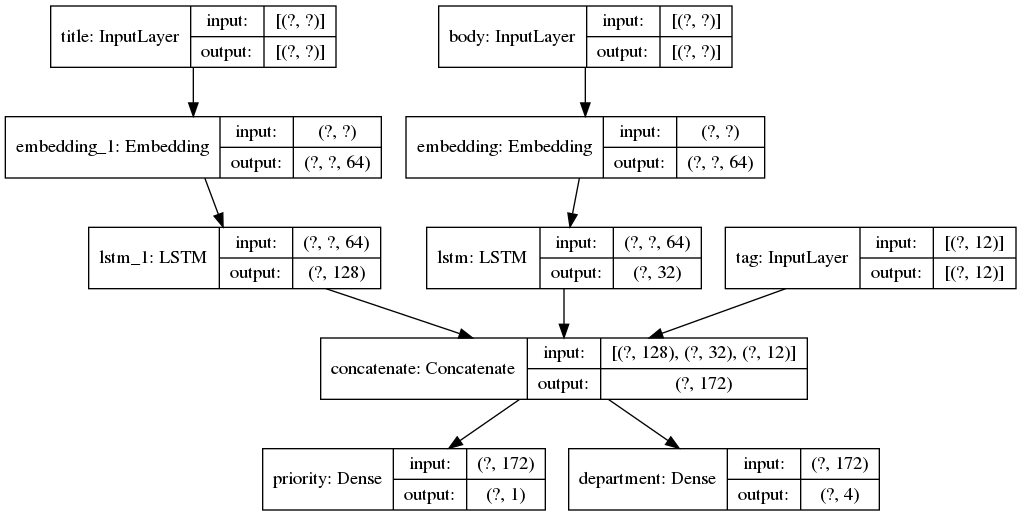

In [9]:
# 构建一个根据定制票标题、内容和标签，预测票证优先级和执行部门的网络
# 超参
num_words = 2000
num_tags = 12
num_departments = 4

# 输入
body_input = keras.Input(shape=(None,), name='body')
title_input = keras.Input(shape=(None,), name='title')
tag_input = keras.Input(shape=(num_tags,), name='tag')

# 嵌入层
body_feat = layers.Embedding(num_words, 64)(body_input)
title_feat = layers.Embedding(num_words, 64)(title_input)

# 特征提取层
body_feat = layers.LSTM(32)(body_feat)
title_feat = layers.LSTM(128)(title_feat)
features = layers.concatenate([title_feat,body_feat, tag_input])

# 分类层
priority_pred = layers.Dense(1, activation='sigmoid', name='priority')(features)
department_pred = layers.Dense(num_departments, activation='softmax', name='department')(features)


# 构建模型
model = keras.Model(inputs=[body_input, title_input, tag_input],
                    outputs=[priority_pred, department_pred])
model.summary()
keras.utils.plot_model(model, 'multi_model.png', show_shapes=True)

编译此模型时，我们可以为每个输出分配不同的loss。甚至可以为每个loss分配不同的权重，以调整它们对总训练loss的贡献。

In [10]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss={'priority': 'binary_crossentropy',
                  'department': 'categorical_crossentropy'},
             loss_weights=[1., 0.2])

In [11]:
# 构造数据并训练

import numpy as np
# 载入输入数据
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tag_data = np.random.randint(2, size=(1280, num_tags)).astype('float32')
# 标签
priority_label = np.random.random(size=(1280, 1))
department_label = np.random.randint(2, size=(1280, num_departments))
# 训练
history = model.fit(
    {'title': title_data, 'body':body_data, 'tag':tag_data},
    {'priority':priority_label, 'department':department_label},
    batch_size=32,
    epochs=5
)

Train on 1280 samples
Epoch 1/5
1280/1280 [==============================] - 6s 5ms/sample - loss: 1.2873 - priority_loss: 0.7099 - department_loss: 2.8868
Epoch 2/5
1280/1280 [==============================] - 1s 1ms/sample - loss: 1.2777 - priority_loss: 0.6978 - department_loss: 2.8995
Epoch 3/5
1280/1280 [==============================] - 1s 1ms/sample - loss: 1.2747 - priority_loss: 0.7001 - department_loss: 2.8730
Epoch 4/5
1280/1280 [==============================] - 1s 1ms/sample - loss: 1.2660 - priority_loss: 0.6968 - department_loss: 2.8459
Epoch 5/5
1280/1280 [==============================] - 1s 1ms/sample - loss: 1.2594 - priority_loss: 0.6972 - department_loss: 2.8109


如果使用Dataset构建输入，它应产生一个列表元组（如）([title_data, body_data, tags_data], [priority_targets, dept_targets]) 或一个字典元组（如） ({'title': title_data, 'body': body_data, 'tags': tags_data}, {'priority': priority_targets, 'department': dept_targets})。



### 3.2 小型残差网络
Functional API还可以使操作非线性连接拓扑变得容易，也就是说，模型中的层不是顺序连接。

常见的用例是残余连接。

下面，我们为CIFAR10建立一个玩具ResNet模型来演示这一点。

Model: "small_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_9[0][0]                   
_______________________________________________________________________________________

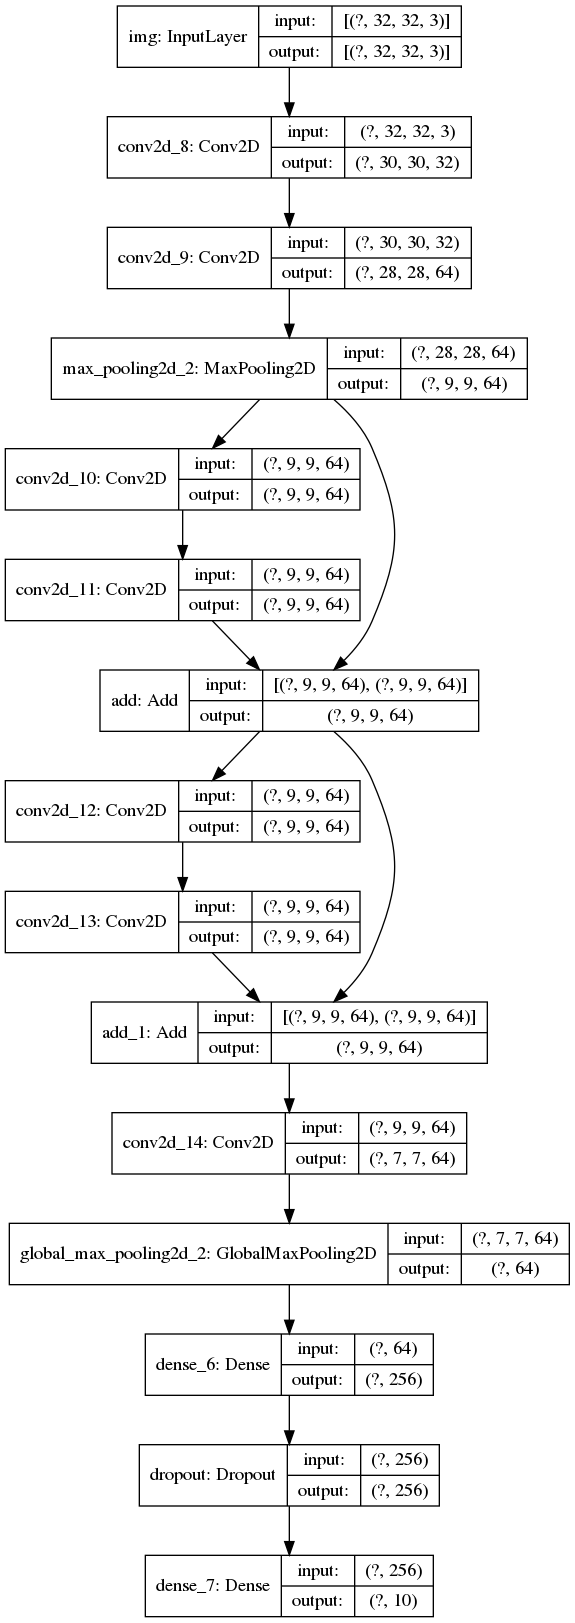

In [12]:
inputs = keras.Input(shape=(32,32,3), name='img')
h1 = layers.Conv2D(32, 3, activation='relu')(inputs)
h1 = layers.Conv2D(64, 3, activation='relu')(h1)
block1_out = layers.MaxPooling2D(3)(h1)

h2 = layers.Conv2D(64, 3, activation='relu', padding='same')(block1_out)
h2 = layers.Conv2D(64, 3, activation='relu', padding='same')(h2)
block2_out = layers.add([h2, block1_out])  # 残差连接

h3 = layers.Conv2D(64, 3, activation='relu', padding='same')(block2_out)
h3 = layers.Conv2D(64, 3, activation='relu', padding='same')(h3)
block3_out = layers.add([h3, block2_out])

h4 = layers.Conv2D(64, 3, activation='relu')(block3_out)
h4 = layers.GlobalMaxPool2D()(h4)
h4 = layers.Dense(256, activation='relu')(h4)
h4 = layers.Dropout(0.5)(h4)
outputs = layers.Dense(10, activation='softmax')(h4)

model = keras.Model(inputs, outputs, name='small_resnet')  # 网络名不能有空格
model.summary()
keras.utils.plot_model(model, 'small_resnet_model.png', show_shapes=True)


训练残差网络

In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = y_train.astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss='categorical_crossentropy',
             metrics=['acc'])
model.fit(x_train, y_train,
         batch_size=64,
         epochs=1,
         validation_split=0.2)

#model.predict(x_test, batch_size=32)

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 91s 2ms/sample - loss: 1.8759 - acc: 0.3005 - val_loss: 1.5772 - val_acc: 0.4288


## 4 共享网络层

函数式API的另一个优点是：可以使用共享层的模型。共享层是在同一模型中多次重用的层实例：它们学习与层图中的多个路径相对应的要素。

共享层通常用于编码来自相似空间的输入（例如，两个具有相似词汇的不同文本），因为它们可以在这些不同输入之间共享信息，并且可以在更少的空间上训练这种模型数据。

要在函数式API中共享图层，只需多次调用同一图层实例即可。例如，这是一个跨两个不同文本输入的共享Embedding图层：

In [14]:
share_embedding = layers.Embedding(1000, 64)

input1 = keras.Input(shape=(None,), dtype='int32')
input2 = keras.Input(shape=(None,), dtype='int32')

feat1 = share_embedding(input1)
feat2 = share_embedding(input2)

## 5 模型复用

由于函数式API中要处理的层图是静态数据结构，因此可以对其进行访问和检查。

这也意味着我们可以访问中间层（图中的“节点”）的输出，并在其他地方重用它们。这对于特征提取非常有用！

下面的一个例子是VGG16模型，其权重在ImageNet上进行了预训练：

In [15]:
from tensorflow.keras.applications import VGG16
vgg16=VGG16()
# 获取中间结构输出
feature_list = [layer.output for layer in vgg16.layers]
# 将其作为新模型输出
feat_ext_model = keras.Model(inputs=vgg16.input, outputs=feature_list)

img = np.random.random((1, 224, 224, 3)).astype('float32')
# 用于提取特征
ext_features = feat_ext_model(img)

## 6 自定义网络层

tf.keras具有广泛的内置层。这里有一些例子：

- 卷积层：Conv1D，Conv2D，Conv3D，Conv2DTranspose，等。
- 池层：MaxPooling1D，MaxPooling2D，MaxPooling3D，AveragePooling1D，等。
- RNN层：GRU，LSTM，ConvLSTM2D，等。
- BatchNormalization，Dropout，Embedding，等。
如果找不到所需的内容，则可以通过创建自己的图层来扩展API。

所有层都对该Layer类进行子类化并实现：
- 一个call方法，指定由该层完成的计算。
- 一种build创建图层权重的方法（请注意，这只是一种样式约定；也可以在__init__函数中创建权重）。

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
my_dense_1 (MyDense)         (None, 10)                50        
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


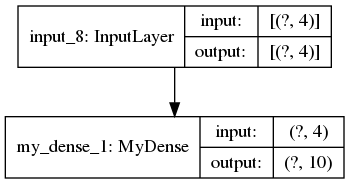

In [16]:
# import tensorflow as tf
# import tensorflow.keras as keras
class MyDense(layers.Layer):
    def __init__(self, units=32):
        super(MyDense, self).__init__()
        self.units = units
    def build(self, input_shape):
        # 构建权重
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
    def call(self, inputs):
        # 正向传播
        return tf.matmul(inputs, self.w) + self.b
    
    def get_config(self):
        # 支持序列化
        return {'units': self.units}
# 构建模型
inputs = keras.Input((4,))
outputs = MyDense(10)(inputs)
model = keras.Model(inputs, outputs)


# 模型序列化
config = model.get_config()
new_model = keras.Model.from_config(
config, custom_objects={'MyDense':MyDense}
)
new_model.summary()
keras.utils.plot_model(new_model, 'myDense.png', show_shapes=True)

**在自定义网络层调用其他网络层**

构建一个rnn网络

(32, 8, 32)
(32, 8, 32)
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(32, 10, 5)]             0         
_________________________________________________________________
conv1d (Conv1D)              (32, 8, 32)               512       
_________________________________________________________________
my_rnn (MyRnn)               (32, 8, 1)                2145      
Total params: 2,657
Trainable params: 2,657
Non-trainable params: 0
_________________________________________________________________


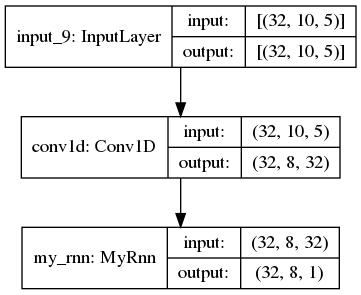

In [17]:
# 超参
time_step = 10
batch_size = 32
hidden_dim = 32
inputs_dim = 5

# 网络
class MyRnn(layers.Layer):
    def __init__(self):
        super(MyRnn, self).__init__()
        self.hidden_dim = hidden_dim
        self.projection1 = layers.Dense(units=hidden_dim, activation='tanh')
        self.projection2 = layers.Dense(units=hidden_dim, activation='tanh')
        self.classifier = layers.Dense(1, activation='sigmoid')
    def call(self, inputs):
        outs = []
        states = tf.zeros(shape=[inputs.shape[0], self.hidden_dim])
        for t in range(inputs.shape[1]):
            x = inputs[:,t,:]
            h = self.projection1(x)
            y = h + self.projection2(states)
            states = y
            outs.append(y)
        # print(outs)
        features = tf.stack(outs, axis=1)
        print(features.shape)
        return self.classifier(features)

# 构建网络
inputs = keras.Input(batch_shape=(batch_size, time_step, inputs_dim))
x = layers.Conv1D(32, 3)(inputs)
print(x.shape)
outputs = MyRnn()(x)
model = keras.Model(inputs, outputs)
model.summary()
keras.utils.plot_model(model, 'myRnn.png', show_shapes=True)

In [18]:
rnn_model = MyRnn()
_ = rnn_model(tf.zeros((1, 10, 5)))

(1, 10, 32)


## 7 何时使用函数式API
如何决定是使用函数式API创建新模型，还是Model直接对类进行子类化？

通常，函数式API是更高级别的，更易于使用和更安全的构建方法，并且具有许多子类化模型不支持的功能。

但是，在创建不容易表示为有向无环图的层的模型时，模型子类化为您提供了更大的灵活性（例如，您无法使用Functional API实现Tree-RNN，您必须Model直接子类化）。

**功能性API的优点如下：**

下面列出的属性对于顺序模型（也是数据结构）也都是正确的，但对于子类模型（它们是Python字节码，不是数据结构）则不是正确的。

- 它不那么冗长。不需要\__init\__函数和call函数。
- 在定义模型时，它将验证模型。
    - 在Functional API中，输入规范（shape和dtype）是预先创建的（通过Input），并且每次调用图层时，该图层都会检查传递给它的规范是否符合其假设。
    - 这样可以保证使用Functional API构建的任何模型都可以运行。所有调试（与收敛相关的调试除外）将在模型构建过程中静态发生，而不是在执行时发生。这类似于在编译器中进行类型检查。
- 函数式模型是可绘制且可检查的。
    - 可以将模型绘制为图形，并且可以轻松访问该图形中的中间节点-例如，以提取和重用中间层的输出。
- 函数式模型模型可以序列化或克隆
    - 因为函数式模型是数据结构而不是一段代码，所以它可以安全地序列化，并且可以保存为单个文件，可以重新创建完全相同的模型，而无需访问任何原始代码。

**功能性API的缺点如下：**
- 它不支持动态架构。
    - Functional API将模型视为层的DAG。对于大多数深度学习架构（但不是全部），这是正确的：但是，递归网络或Tree RNN不遵循此假设，并且无法在Functional API中实现。

- 有时，需要从头开始编写所有内容。
    - 在编写高级体系结构时，可能想做“定义层的DAG”范围之外的事情：例如，可能需要在模型实例上公开多个自定义训练和推理方法。这需要子类化。

